We want to have a database of active constituents we consider for portfolio selection before we can do any factor research.

Our rule is simple - get the 1000 highest market cap stocks, and take them for consideration.

In [118]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv('../.env')
db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [ ]:
# our biggest problem is outliers due to data errors/anomalies.
# we will try our best to limit these, using some fairly elementary strategies

In [13]:
data = pd.read_sql("select * from eom_factors where factor in ('marketcap', 'ev', 'pe')", psql)

In [ ]:
wide_data = data.pivot(
    index=['date', 'ticker'],
    columns='factor',
    values='value'
).reset_index()
wide_data['date'] = pd.to_datetime(wide_data['date'])

In [16]:
wide_data.sort_values('marketcap')

factor,date,ticker,ev,marketcap,pe
1312699,2017-05-31,AYTU,-3.5,0.0,0.0
1218948,2015-11-30,BODY1,10.9,0.0,0.0
458965,2004-09-30,DCSR,2.0,0.0,0.0
1130721,2014-06-30,PTIX,2.0,0.0,0.0
587403,2006-06-30,BBUCQ,18.4,0.0,0.0
...,...,...,...,...,...
587148,2006-06-30,APDN,5248414.2,5248412.6,-482657.0
630033,2007-01-31,APDN,5998187.4,5998185.8,-551608.0
648234,2007-04-30,APDN,6373074.1,6373072.5,-586083.5
642166,2007-03-31,APDN,7497733.9,7497732.3,-689510.1


The problem above is pretty clear, `APDN` (Applied DNA Sciences Inc.) is supposed valued at 7.5 trillion USD in 2007. We'll work around these by filtering outliers out by *PE*, which appears to be a more robust way fo checking for outliers, and we'll see the results from there.

As an example, consider the P/E of the most recent date.

In [18]:
wide_data[wide_data['date'] == wide_data['date'].max()].sort_values('marketcap')

factor,date,ticker,ev,marketcap,pe
1861909,2025-08-31,BINI,22.9,0.0,0.0
1865069,2025-08-31,PLRZ,-2.6,0.0,0.0
1863254,2025-08-31,GDHG,-58.5,0.1,0.0
1863572,2025-08-31,HSDT,-1.0,0.1,0.0
1864894,2025-08-31,OST,23.5,0.2,0.0
...,...,...,...,...,...
1861548,2025-08-31,AMZN,2451167.3,2374969.3,33.6
1863361,2025-08-31,GOOGL,2450496.5,2435973.5,21.1
1861275,2025-08-31,AAPL,3469072.4,3403643.4,34.3
1864459,2025-08-31,MSFT,3846433.2,3880410.2,38.1


I think clipping within 1% bounds will be enough. This might clip so very overvalued stocks in some dates, but this is better than believing that APDN is the highest valued stock in the entire universe in 2007.

So for each day, remove any stocks that have a statistically improbable `PE` ratio, and then get the names of the top 1000 stocks.

In [275]:
filter_history = []
constituent_history = []

ticker_data = pd.read_csv('~/Downloads/tickers.csv')

# we don't allow ADRs and ETFs
ticker_data = ticker_data[
    (ticker_data['category'] != 'ADR Common Stock') &
    (ticker_data['category'] != 'ADR Common Stock Primary Class') &
    (ticker_data['category'] != 'ETF')
]
ticker_data = ticker_data[['ticker', 'sector']].dropna().drop_duplicates(['ticker'])

# ensure dates are sorted
for date, date_data in wide_data.groupby("date"):
    date_data = date_data.copy()
    date_data["year"] = date_data["date"].dt.year
    date_data["month"] = date_data["date"].dt.month

# pick one rebalance month per year (e.g., June = 6)
rebalance_month = 6
rebalance_dates = (
    wide_data[wide_data["date"].dt.month == rebalance_month]["date"].unique()
)

# dictionary to hold latest rebalance portfolio
latest_portfolio = None
latest_year = None

for date, date_data in wide_data.groupby("date"):
    year = date.year
    month = date.month

    # if this is a rebalance month, select new top 1000
    if month == rebalance_month:
        lo, hi = date_data["pe"].quantile([0.01, 0.99])
        mask = date_data["pe"].between(lo, hi)
        valid_data = date_data[mask].merge(ticker_data, on='ticker')

        top1000 = (
            valid_data.sort_values("marketcap", ascending=False)
            .head(1000)
            .copy()
        )
        top1000["index_weight"] = (
            (top1000["ev"] / top1000["ev"].sum())
        )
        latest_portfolio = top1000[["date", "ticker", "index_weight", 'sector']].copy()
        latest_year = year

        filter_history.append({"date": date, "lo": lo, "hi": hi})

    # for non-rebalance months, reuse latest portfolio but stamp with current date
    if latest_portfolio is not None:
        temp = latest_portfolio.copy()
        temp["date"] = date   # overwrite date so we get 12 months
        constituent_history.append(temp)

constituent_history = pd.concat(constituent_history, ignore_index=True)
constituent_history['date'] = pd.to_datetime(constituent_history['date'])

Let's quickly plot the P/E bounds to see if they look fairly sensible across history.

Text(0, 0.5, 'P/E Ratio Filter')

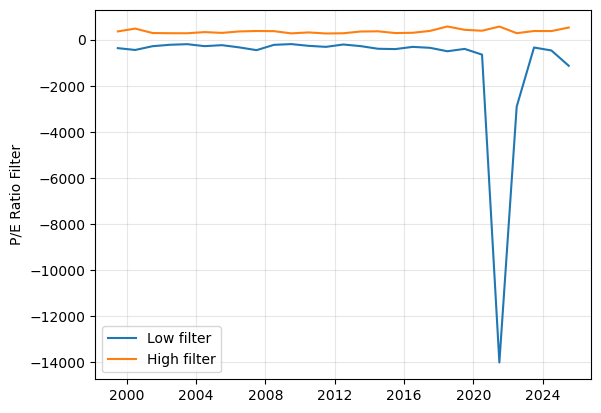

In [202]:
filter_df = pd.DataFrame(filter_history)
plt.plot(filter_df['date'], filter_df['lo'], label='Low filter')
plt.plot(filter_df['date'], filter_df['hi'], label='High filter')
plt.grid(alpha=0.3)
plt.legend()
plt.ylabel('P/E Ratio Filter')

We can see during COVID that the profitability of some stocks crashes; this makes sense particularly for mid to small cap U.S equities.

In [276]:
russell_1000_proxy = constituent_history.copy()
# we avoid lookahead bias (we don't know the market cap until after the day's close)
# leaking this data might be 
russell_1000_proxy['date'] = pd.to_datetime(russell_1000_proxy['date']) + pd.DateOffset(months=1)
russell_1000_proxy['date'] = russell_1000_proxy['date'].dt.date
russell_1000_proxy['index'] = 'Russell 1000'
russell_1000_proxy.to_sql('monthly_constituents', psql, if_exists='append', index=False)

1000

An interesting experiment would be to construct cumulative returns for our Russell 1000 proxy and see how well it tracks the actual Russell 100 ETF. An obvious flaw is that we rebalance monthly.

In [280]:
russell_1k = pd.read_sql("select * from eom_prices where ticker = 'IWB'", psql)
russell_1k = russell_1k.sort_values('date')
russell_1k['date'] = pd.to_datetime(russell_1k['date'])
russell_1k['return'] = russell_1k['price'].pct_change()
russell_1k['cumulative_return'] = (1 + russell_1k['return']).cumprod() - 1
russell_1k = russell_1k.dropna()

stock_prices = pd.read_sql('select * from eom_prices', psql)
stock_prices['date'] = pd.to_datetime(stock_prices['date'])
stock_prices = stock_prices.merge(constituent_history, on=['date', 'ticker'])

stock_prices['prev_date'] = stock_prices.groupby('ticker')['date'].shift()

month_diff = (
    (stock_prices['date'].dt.year - stock_prices['prev_date'].dt.year) * 12
    + (stock_prices['date'].dt.month - stock_prices['prev_date'].dt.month)
)

stock_prices['return'] = (
    stock_prices.groupby('ticker')['price'].pct_change()
    .where(month_diff == 1)   # set to NaN if gap > 1
)

stock_prices = stock_prices.drop(columns=['prev_date']).dropna()

In [283]:
# sort by date and ticker

russell_1k_proxy = (
    stock_prices
    .groupby("date", group_keys=False)
    .apply(lambda g: np.average(g["return"], weights=g["index_weight"]))
    .reset_index(name='return')
)
russell_1k_proxy['cumulative_return'] = (1 + russell_1k_proxy['return']).cumprod() - 1

/var/folders/qq/9n_h2x6x0pl9pvyr0gpk4m_r0000gn/T/ipykernel_65262/3909673509.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g["return"], weights=g["index_weight"]))


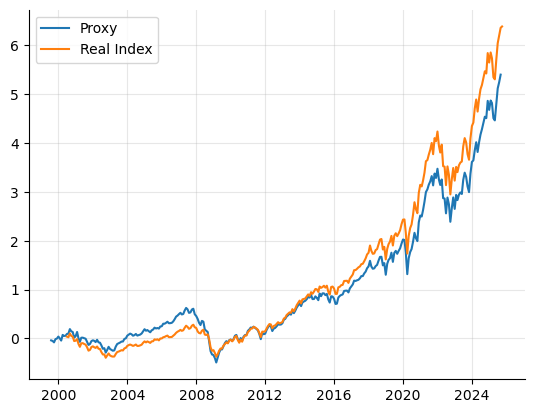

In [285]:
plt.plot(russell_1k_proxy['date'], russell_1k_proxy['cumulative_return'], label='Proxy')
plt.plot(russell_1k['date'], russell_1k['cumulative_return'], label='Real Index')
sns.despine()
plt.legend()
plt.grid(alpha=0.3)

The proxy is actually pretty good! It is clearly overweighting some of the larger cap stocks (that have overperformed in recent decades). It clearly has a beta to the real Russell 1000 index, which is the important part for us.

In [286]:
russell_real = russell_1k[['date', 'return']].rename(columns={'return': 'real'})
russell_proxy = russell_1k_proxy[['date', 'return']].rename(columns={'return': 'proxy'})
russell_data = russell_real.merge(russell_proxy, on='date')

Alpha: 0.0014632876867246272
Beta: 0.8432465946289718


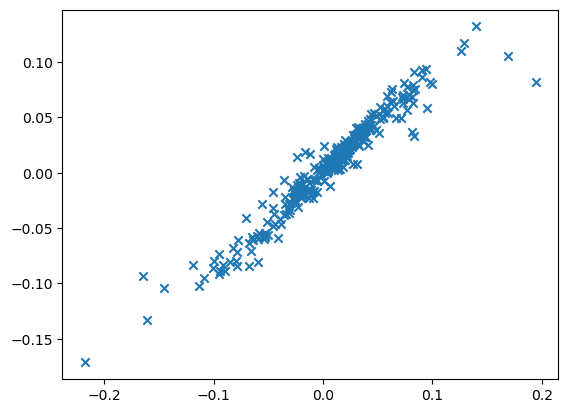

In [287]:
plt.scatter(russell_data['proxy'], russell_data['real'], marker='x')
beta, alpha = np.polyfit(russell_data["proxy"], russell_data["real"], 1)
print("Alpha:", alpha)
print("Beta:", beta)